# Solving the Vlasov-Poisson equation using Python

A plasma is a quasi-neutral gas of charged and neutral particles showing non-trivial collective behavior, distinct from other states of matter. The dynamics of plasma can be derived from the Boltzmann equation, where we can usually assume that we have a negligible amount of collisions. This leads us to the collisionless Boltzmann or **Vlasov equation**. In this tutorial, we want to simulate a simple one-dimensional plasma using the Vlasov equation and look at Landau damping and two kinetic instabilities. Since in one dimension we can't have any magnetic fields, we actually solve the electrostatic Vlasov-Poisson equation.

## Theory

If we want to simulate moving electrons, in principle we have to solve the full Maxwell system of equations, containing $E$ and $B$ fields. Since in the following we can safely assume the speed of the electrons $v$ to be much smaller than the speed of light $c$, i.e., $v\ll c$, we can neglect the contribution of the magnetic field and assume the effect of the electric field to be instantaneous. We know that the divergence of the electric field equals the charge density $$\nabla\cdot E=4\pi\rho$$ (in CGS units) and that in electrostatics the electric field can be derived from an electric potential $$E=-\nabla\phi.$$ Combined, we find Poissons equation for electrostatics $$\Delta\phi=4\pi\rho.$$ 

When simulating plasma, computational physicists usually use either the fluid discription of plasmas, called Magneto-Hydrodynmaics (MHD), or the semi-lagrangian Particle-In-Cell (PIC) method to sample the Vlasov equation. However, both approaches have their drawbacks. For example, the MHD theory is based on a few but fundamental assumptions which break down in certain, very interesting, regimes. PIC on the other hand does not have the limits on, e.g., resitivity, but needs a computationally very intensive amount of particles to generate solutions with a reasonable low amount of noise at a given space-time resolution.

The idea of simulating the Vlasov equation is to directly evolve the probability distribution function $f$ to find a charged particle in a given phase space region $\mathrm{d}x\mathrm{d}v$ at time $t$, i.e., the Vlasov equation is a 6+1 dimensional scalar function of position and velocity. However, since this is difficult to solve and we already learn a lot from simpler systems, we restrict the following discussion to the one-dimensional case. 

For a plasma there are usually two distribution functions, one for ions and one for electrons. But since ion mass is typically much larger than the electron mass ($m_i\gg m_e$), electrons more much faster than ions. In such a case, we can assume a neutralizing ion background and only simulate electron dynamics. Using our assumptions, the Vlasov equation can be written as $$\frac{\mathrm{d}}{\mathrm{d}t} f(x, v,t) = 0,$$
where charge density is then simply the first moment of the Vlasov equation times the electron charge $q_e$ $$\rho(x,t)=q_e\int f(x,v,t) \mathrm{d}v$$

Taking the total time derivative of $f$ using the chain rule we find the plasma kinetic equation $$\frac{\mathrm{d}}{\mathrm{d}t} f=\frac{\partial f}{\partial t}+\frac{\partial x}{\partial t}\frac{\partial f}{\partial x}+\frac{\partial v}{\partial t}\frac{\partial f}{\partial v}=0$$

By identifying $\frac{\partial x}{\partial t}=v$ and $\frac{\partial v}{\partial t}=a$ and using the equation for electrostatic force $F_E=m_ea=q_e E$ we derived the 1D Vlasov-Poisson equation: $$\frac{\partial f}{\partial t}+v\frac{\partial f}{\partial x}+\frac{q_\alpha E}{m}\frac{\partial f}{\partial v}=0.$$ The form of this equation resembles a _hyperbolic conservation law_ that can be computed numerically by employing standard techniques of fluid dynamics. For simplicity, in this tutorial we use the so-called upwind scheme.



# Implementation

To run the simulation of the Vlasov equation on a computer we have to implement a finite difference scheme. As our programming language of choice is python, we have to take special care on performance. This obscures the readability of the code but makes python code run nearly as fast as C code. First we need to import our favorite libraries. Here we will mainly rely on `numpy` for computation and `matplotlib` for visualization.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tqdm
from maxpy.style import dark_mode

dark_mode(background="#191c1c")

CMAP = plt.get_cmap("cmr.chroma")

## Computing the electric field from a charge density using Fourier transforms

### Fourier transform conventions

We define the Fourier transform and its inverse as

$$
f(\mathbf{k}) = \int_{\mathbb{R}^3} f(\mathbf{r}) e^{-i\mathbf{k}\cdot\mathbf{r}} \, d^3 r
$$

$$
f(\mathbf{r}) = \frac{1}{(2\pi)^3} \int_{\mathbb{R}^3} f(\mathbf{k}) e^{i\mathbf{k}\cdot\mathbf{r}} \, d^3 k
$$

Different conventions may redistribute factors of $2\pi$ without changing physical results.

### Poisson’s equation in Fourier space

Using the correspondence

$$\nabla^2 \longrightarrow -k^2$$

Poisson’s equation becomes

$$-k^2 \phi(\mathbf{k}) = -4\pi\rho(\mathbf{k})$$

Solving for the potential gives

$$\phi(\mathbf{k}) = \frac{4\pi\rho(\mathbf{k})}{k^2}$$

This expression is valid for $k \neq 0$. The $k = 0$ mode corresponds to the total charge and requires separate treatment.

### Electric field in Fourier space

Since $\mathbf{E} = -\nabla \phi$ and

$$\nabla \longrightarrow i\mathbf{k}$$

the electric field in Fourier space is

$$\mathbf{E}(\mathbf{k}) = -i\mathbf{k}\,\phi(\mathbf{k})
= -i\mathbf{k}\,\frac{4\pi\rho(\mathbf{k})}{k^2}$$

or equivalently

$$\mathbf{E}(\mathbf{k}) = i\frac{\mathbf{k}}{k^2}4\pi\rho(\mathbf{k})$$

### Transforming back to real space

The real-space electric field is obtained by inverse Fourier transform:

$$\mathbf{E}(\mathbf{r}) =
\frac{1}{(2\pi)^3}
\int d^3 k \;
\frac{i\mathbf{k}}{k^2}\,
\rho(\mathbf{k})\,
e^{i\mathbf{k}\cdot\mathbf{r}}$$

This expression is equivalent to Coulomb’s law:

$$\mathbf{E}(\mathbf{r}) = \int d^3 r' \;
\rho(\mathbf{r}')
\frac{\mathbf{r}-\mathbf{r}'}{|\mathbf{r}-\mathbf{r}'|^3}$$

### Practical algorithm

Given $\rho(\mathbf{r})$:

1. Compute $\rho(\mathbf{k})$ via a Fourier transform.
2. Multiply by $\frac{i\mathbf{k}}{k^2}$ in Fourier space.
3. Apply the inverse Fourier transform to obtain $\mathbf{E}(\mathbf{r})$.

Using spectral solvers for the Poisson equation is especially useful when we deal with periodic boundary conditions, since they are satisfied by definition. The real benefit, however, comes from the Fast Fourier Transform (FFT).

In [15]:
def solve_poisson_fft(rho, dx, nx):
    rho_k = np.fft.fft(rho)
    k_vals = 2 * np.pi * np.fft.fftfreq(nx, d=dx)

    E_k = np.zeros_like(rho_k, dtype=complex)
    nonzero = k_vals != 0
    E_k[nonzero] = (1j / k_vals[nonzero]) * rho_k[nonzero]

    E = np.real(np.fft.ifft(E_k))
    return E

## Upwind scheme

The upwind scheme is a finite difference or finite volume discretization method for hyperbolic partial differential equations. It accounts for the direction of information propagation.

### 1. Model problem

Consider the linear advection equation

$$\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0$$

where $a$ is a constant advection velocity. Characteristics propagate with speed $a$. The numerical flux is constructed using information from the upstream direction.

- If $a > 0$, information travels from left to right.
- If $a < 0$, information travels from right to left.

### First order upwind discretization

Let $u_i^n \approx u(x_i, t^n)$ with spatial step $\Delta x$ and time step $\Delta t$.

#### Case $a > 0$

$$\frac{\partial u}{\partial x}\bigg|_{x_i} \approx \frac{u_i^n - u_{i-1}^n}{\Delta x}$$

The time update is

$$u_i^{n+1}=u_i^n-\frac{a \Delta t}{\Delta x}\left(u_i^n - u_{i-1}^n\right)$$

#### Case $a < 0$

$$\frac{\partial u}{\partial x}\bigg|_{x_i}\approx\frac{u_{i+1}^n - u_i^n}{\Delta x}$$

### Conservative finite volume form

For a conservation law

$$\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0$$

the upwind numerical flux at interface $i+1/2$ is

$$F_{i+1/2} =
\begin{cases}
f(u_i), & f'(u) > 0 \\
f(u_{i+1}), & f'(u) < 0
\end{cases}$$

For linear advection $f(u) = a u$, this reduces to the previous formulas.

### Stability condition

The upwind scheme is stable under the CFL condition

$$\frac{|a|\Delta t}{\Delta x} \le 1$$

With that, the method is first order accurate in space and in time. However, it introduces numerical diffusion proportional to $\Delta x$. The main advantage is that its unconditionally stable for hyperbolic problems and rather simple to implement. The disadvantage is low accuracy and smoothed gradients at shocks.

For our specific problem of the 1D Vlasov-Poisson equation, we have to split the advection in two steps, one to advance in velocity space and one to advance in position space, where we use different upwind conditions. We can achieve that in python by looping over all position and velocity cells and deciding case per case which sign to choose.

In [16]:
def _advance_velocity(f, dx, dt, nx, nv, v):
    for i in range(nx - 1):
        for j in range(nv - 1):
            if v[j] > 0:
                f[i, j] = f[i, j] - dt / dx * (f[i, j] * v[j] - f[i - 1, j] * v[j])
            else:
                f[i, j] = f[i, j] - dt / dx * (f[i + 1, j] * v[j] - f[i, j] * v[j])
    return f


def _advance_position(f, dv, dt, nx, nv, E):
    for i in range(nx - 1):
        for j in range(nv - 1):
            if E[i] > 0:
                f[i, j] = f[i, j] - dt / dv * (f[i, j] - f[i, j - 1]) * E[i]
            else:
                f[i, j] = f[i, j] - dt / dv * (f[i, j + 1] - f[i, j]) * E[i]
    return f

However, this is very slow in python. We can significantly increase the speed by using numpy vectorization. This obscures the readability of the code, however results in a performance boost of approximately 100 times as fast as simple loops. The updates than look like the following functions


In [17]:
def advance_velocity(f, v, dx, dt, v_mask, v_mask_not):
    f[:, v_mask] = f[:, v_mask] - dt / dx * (f - np.roll(f, 1, axis=0))[:, v_mask] * v[v_mask]
    f[:, v_mask_not] = f[:, v_mask_not] - dt / dx * (np.roll(f, -1, axis=0) - f)[:, v_mask_not] * v[v_mask_not]
    return f


def advance_position(f, E, dv, dt, E_mask, E_mask_not):
    f[E_mask, :] = f[E_mask, :] - dt / dv * (f - np.roll(f, 1, axis=1))[E_mask, :] * E[E_mask][..., np.newaxis]
    f[E_mask_not, :] = (
        f[E_mask_not, :] - dt / dv * ((np.roll(f, -1, axis=1) - f)[E_mask_not, :]) * E[E_mask_not][..., np.newaxis]
    )
    return f


Finally we can put everything together and implement the time loop. We store the results of every m'th time step into an array for later processing, such as creating a gif of the evolution.


In [18]:
def get_initial_distribution(params):
    # Allocate memory for the distribution function
    f = np.zeros((params["nx"], params["nv"]))
    x = np.linspace(0, params["L"], params["nx"], endpoint=False)
    v = np.linspace(params["vmin"], params["vmax"], params["nv"])
    dv = np.abs(v[1] - v[0])  # velocity step size
    dx = np.abs(x[1] - x[0])  # spatial step size
    dt = params["CFL"] * min(dx / params["vmax"], dv / 1.0)  # assuming max|E| ~ 1

    print("Simulation parameters:")
    print(f"  Spatial step size (dx): {dx}")
    print(f"  Velocity step size (dv): {dv}")
    print(f"  Time step size (dt): {dt}")

    return f, x, v, dx, dv, dt


def plot_distribution(f, x, v):
    # plt.figure(figsize=(6, 4), dpi=100)
    plt.imshow(f.T, cmap=CMAP, aspect="auto", origin="lower", extent=[x.min(), x.max(), v.min(), v.max()])
    # plt.colorbar()
    plt.title("Distribution function $f(x,v)$")
    plt.xlabel("Position $x$")
    plt.ylabel("Velocity $v$")
    # plt.show()
    return


def run_simulation(f, x, v, dx, dv, dt, params):
    # Allocate memory for the results
    result = np.zeros((params["maxiter"] // params["save_interval"], params["nx"], params["nv"]))
    E_k_hist = []

    # Get masks for upwind schemes
    v_mask = np.argwhere(v > 0)
    v_mask_not = np.argwhere(v <= 0)

    for it in tqdm.tqdm(range(params["maxiter"])):
        # Advance velocity distribution
        f_new = advance_velocity(f, v, dx, dt, v_mask, v_mask_not)

        # Integrate f along velocity axis to get charge density
        rho = params["q_e"] * np.trapezoid(f_new, dx=dv, axis=1)

        # Add constant ion background
        rho = rho - np.mean(rho)

        # Solve Poisson equation
        E = solve_poisson_fft(rho, dx, params["nx"])

        # Get mask for upwind scheme
        E_mask = np.argwhere(E > 0)
        E_mask_not = np.argwhere(E <= 0)

        # Advance position distribution
        f_new = advance_position(f_new, E, dv, dt, E_mask, E_mask_not)

        if params["export_mode"]:
            # Solve Poisson with FFT
            rho_k = np.fft.fft(rho)
            k_vals = 2 * np.pi * np.fft.fftfreq(params["nx"], d=dx)

            # Avoid division by zero at k=0
            E_k = np.zeros_like(rho_k, dtype=complex)
            nonzero = k_vals != 0
            E_k[nonzero] = (1j / k_vals[nonzero]) * rho_k[nonzero]
            E = np.real(np.fft.ifft(E_k))

            # Save fundamental mode (k=±1 depending on domain length L)
            # If domain length is L=2π/k0, then fundamental mode index is 1
            E1 = E_k[1] / params["nx"]
            E_k_hist.append(E1)

        # Save every mth step
        if it % params["save_interval"] == 0:
            result[it // params["save_interval"]] = f.copy()
            if params["plot"]:
                plot_distribution(f, x, v)
                plt.savefig(f"/home/max/Temp/{params['name']}_{it:05d}.png")
    return result, E_k_hist

## Kinetic instabilities in collisionless plasmas

In collisionless plasmas, wave propagation and stability are described by the Vlasov equation coupled to Poisson’s equation. Landau damping, the two stream instability, and the bump on tail instability arise from resonant wave particle interactions.

Linearizing around a homogeneous equilibrium $f_0(v)$ leads to the electrostatic dispersion relation

$$1 + \frac{1}{k^2 \varepsilon_0}\sum_s \frac{q_s^2}{m_s}\int \frac{\partial f_{0s}/\partial v}{v - \omega/k} \, dv= 0$$

## Landau damping

Landau damping occurs when the equilibrium distribution function $f_0(v)$ is monotonic decreasing. The imaginary part of the wave frequency is obtained by evaluating the dispersion relation using the Landau contour, yielding

$$\gamma =\operatorname{Im}(\omega)=-\frac{\pi}{2}\frac{\omega_p^2}{k}\left.\frac{\partial f_0}{\partial v}\right|_{v = \omega_r/k}$$

where $\omega_p$ is the plasma frequency and $\omega_r$ is the real part of the wave frequency. For $\partial f_0 / \partial v < 0$, the damping rate $\gamma$ is negative, corresponding to exponential decay of the wave amplitude.


Simulation parameters:
  Spatial step size (dx): 0.4870686284635338
  Velocity step size (dv): 0.15625
  Time step size (dt): 0.02435343142317669


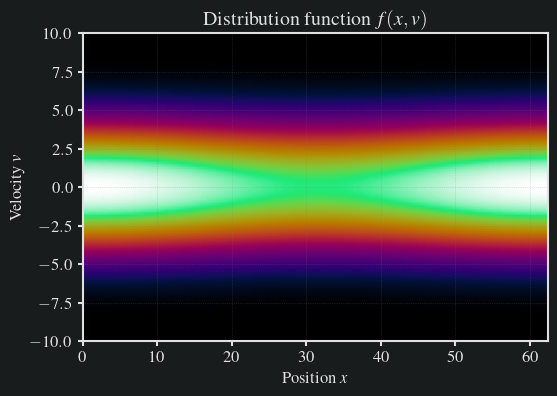

In [19]:
params = {
    "nx": 128 + 1,  # Number of spatial positions
    "nv": 128 + 1,  # Number of velocity values
    "vmin": -10,  # Minimal possible velocity
    "vmax": 10,  # Maximal possible velocity
    "q_e": -1,  # Electron charge
    "n_particles": 1,  # Initial particle number
    "k": 0.1,  # wave number of perturbation
    "L": 2 * np.pi / 0.1,  # domain length for k
    "CFL": 0.5,  # CFL number
    "maxiter": 4000,  # Maximum number of iterations
    "plot": True,  # Whether to plot intermediate results
    "save_interval": 100,  # Save every mth step
    "export_mode": True,  # Whether to export mode data
    "save_path": "/home/max/Temp",  # Path to save output files
    "name": "landau_damping",  # Simulation name
}


def maxwellian(v, vbeam, vth):
    return np.exp(-0.5 * ((v - vbeam) / vth) ** 2) / (np.sqrt(2 * np.pi) * vth)


# Get initial distribution and simulation parameters
f, x, v, dx, dv, dt = get_initial_distribution(params)

# Maxwellian
vth = 3.0
f0 = maxwellian(v, 0.0, vth)

# Small perturbation
alpha = 1e-1
f = np.zeros((params["nx"], params["nv"]))
for i in range(params["nx"]):
    f[i, :] = f0 * (1 + alpha * np.cos(params["k"] * x[i]))

# Normalize the distribution
f = f / f.sum()

plot_distribution(f, x, v)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:38<00:00, 102.75it/s]


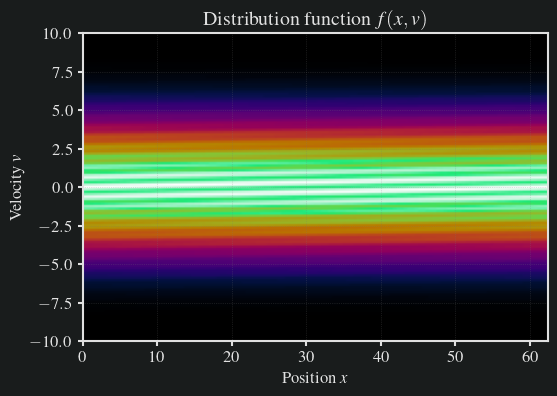

In [20]:
result, E_k_hist = run_simulation(f, x, v, dx, dv, dt, params)

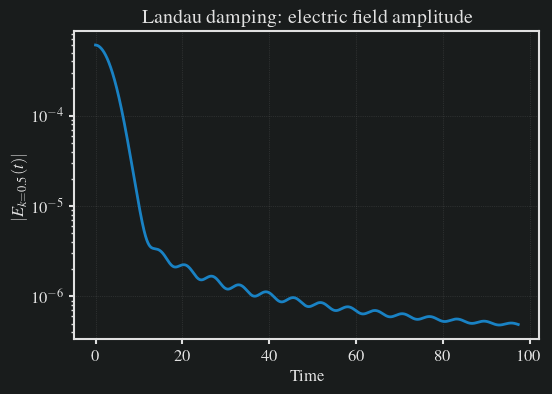

In [21]:
E_k_hist = np.array(E_k_hist)
t = np.arange(len(E_k_hist)) * dt

# Amplitude of first Fourier mode
amp = np.abs(E_k_hist)

plt.plot(t, amp)
plt.yscale("log")
plt.xlabel("Time")
plt.ylabel(r"$|E_{k=0.5}(t)|$")
plt.title("Landau damping: electric field amplitude")
plt.show()


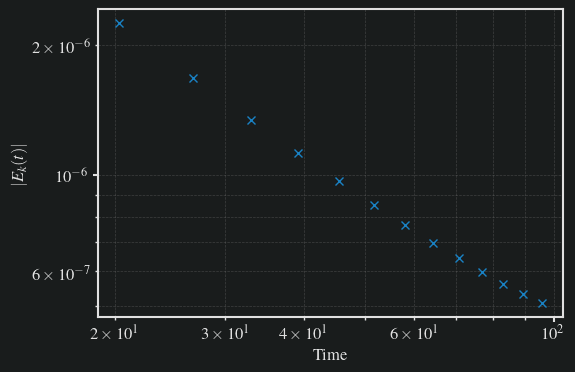

Numerical damping rate gamma = -0.0184


In [22]:
# find peaks
peaks, _ = scipy.signal.find_peaks(amp)
plt.plot(t[peaks], amp[peaks], "x")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel(r"$|E_k(t)|$")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

# get slope
fit_range = (t > 0.5) & (t < 30)
slope, intercept, *_ = scipy.stats.linregress(t[peaks], np.log(amp[peaks]))

print(f"Numerical damping rate gamma = {slope:.4f}")

## Two stream instability

The two stream instability arises when the equilibrium distribution consists of two drifting populations. A simple cold plasma model uses

$$f_0(v) =\frac{n_0}{2}\left[\delta(v - v_0) + \delta(v + v_0)\right]$$

The resulting dispersion relation is

$$1 - \frac{\omega_p^2}{(\omega - k v_0)^2}- \frac{\omega_p^2}{(\omega + k v_0)^2}= 0$$

For sufficiently large drift velocity $v_0$, this equation admits solutions with $\operatorname{Im}(\omega) > 0$, indicating exponential growth of electric field perturbations.


Simulation parameters:
  Spatial step size (dx): 0.9961089494163424
  Velocity step size (dv): 0.078125
  Time step size (dt): 0.0390625


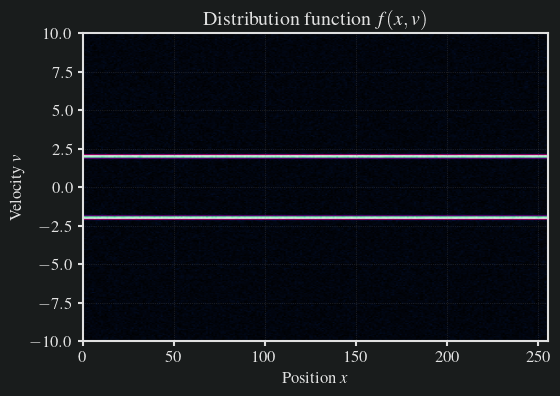

In [27]:
params = {
    "nx": 256 + 1,
    "nv": 256 + 1,
    "vmin": -10,
    "vmax": 10,
    "q_e": -1000,
    "n_particles": 1,
    "k": 0.1,
    "L": 256,
    "CFL": 0.5,
    "maxiter": 4000,
    "plot": True,
    "save_interval": 100,
    "export_mode": True,
    "save_path": "/home/max/Temp",
    "name": "two_stream_instability",
}

# Get initial distribution and simulation parameters
f, x, v, dx, dv, dt = get_initial_distribution(params)

vth = 0.01 * params["vmax"]  # Thermal velocity
vbeam = 0.2 * params["vmax"]  # Beam velocity

# Initial distribution for two-stream instability
for i in range(params["nv"]):
    f[:, i] = np.exp(-((v[i] - vbeam) ** 2) / vth**2) + np.exp(-((v[i] + vbeam) ** 2) / vth**2)

# Add noise
f += np.random.normal(0, 0.01, f.shape)

# Normalize the distribution
f = f / f.sum()

# Plot initial distribution
plot_distribution(f, x, v)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:43<00:00, 91.53it/s] 


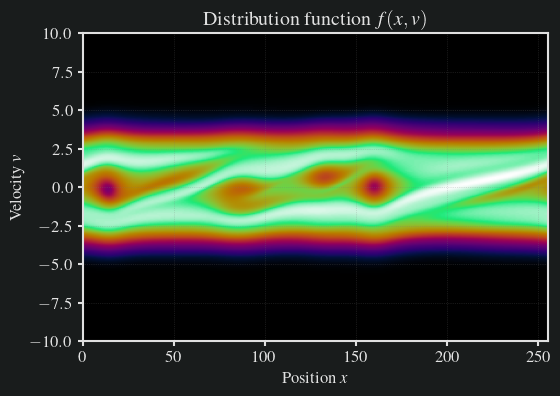

In [28]:
result, E_k_hist = run_simulation(f, x, v, dx, dv, dt, params)

## Bump on tail instability

The bump on tail instability occurs when the distribution function has a local maximum at high velocity, so that

$$\left.\frac{\partial f_0}{\partial v}\right|_{v = \omega/k}> 0$$

The growth rate follows the same expression as Landau damping but with opposite sign,

$$\gamma =-\frac{\pi}{2}\frac{\omega_p^2}{k}\left.\frac{\partial f_0}{\partial v}\right|_{v = \omega_r/k}$$

A positive slope at the resonant velocity leads to $\gamma > 0$, corresponding to wave amplification.


Simulation parameters:
  Spatial step size (dx): 0.24448191856729906
  Velocity step size (dv): 0.078125
  Time step size (dt): 0.012224095928364953


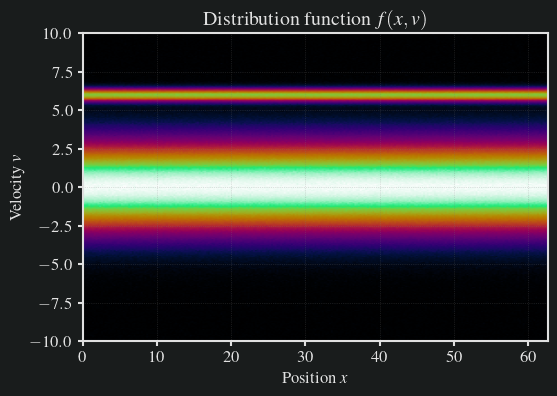

In [25]:
params = {
    "nx": 256 + 1,
    "nv": 256 + 1,
    "vmin": -10,
    "vmax": 10,
    "q_e": -1,
    "n_particles": 1,
    "k": 0.1,
    "L": 2 * np.pi / 0.1,
    "CFL": 0.5,
    "maxiter": 4000,
    "plot": True,
    "save_interval": 100,
    "export_mode": True,
    "save_path": "/home/max/Temp",
    "name": "bump_on_tail",
}

# Get initial distribution and simulation parameters
f, x, v, dx, dv, dt = get_initial_distribution(params)

vth = 0.2 * params["vmax"]  # Thermal velocity
vbeam = 0.6 * params["vmax"]  # Beam velocity

alpha_b = 0.1
eps = 1e-4

fM = lambda v, u, vt: np.exp(-((v - u) ** 2) / (2 * vt**2)) / (np.sqrt(2 * np.pi) * vt)

f0v = (1 - alpha_b) * fM(v, 0, vth) + alpha_b * fM(v, vbeam, 0.3)

f = np.zeros((params["nx"], params["nv"]))
for i in range(params["nx"]):
    f[i, :] = f0v * (1 + eps * np.cos(10 * x[i]))

f += np.random.normal(0, 0.001, f.shape)

f /= np.sum(f[0, :]) * dv

# Plot initial distribution
plot_distribution(f, x, v)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:43<00:00, 92.12it/s] 


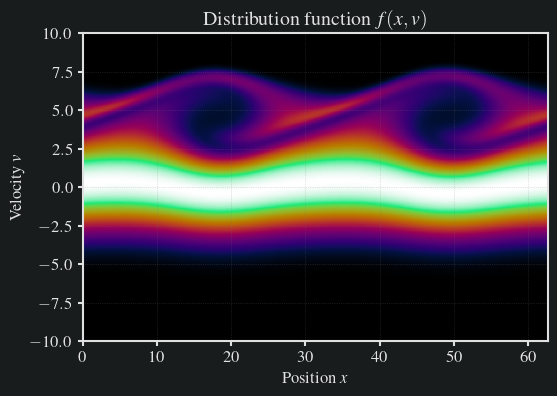

In [26]:
result, E_k_hist = run_simulation(f, x, v, dx, dv, dt, params)

### Summary

All three phenomena are described by the same linearized Vlasov dispersion relation. Landau damping corresponds to negative slope of the distribution function at resonance, while the two stream and bump on tail instabilities arise from nonmonotonic velocity distributions that provide free energy for wave growth.

The jupyter notebook of this tutorial can be downloaded ![here](/docs/vlasov_simulation_fft.ipynb)


In [32]:
import subprocess

def create_video(name):
    subprocess.run(["ffmpeg", "-framerate", "15", "-pattern_type", "glob", "-i", f"/home/max/Temp/{name}_*.png", "-c:v", "libx264", "-preset", "slow", "-crf", "18", "-pix_fmt", "yuv420p", f"/home/max/Repos/portfolio/static/videos/{name}.mp4"])

create_video("landau_damping")
create_video("two_stream_instability")
create_video("bump_on_tail")

ffmpeg version n8.0.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.1 (GCC) 20251112
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enab